# 👾 PixelCNN - 텐서플로 확률 라이브러리

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/05_autoregressive/03_pixelcnn_md/pixelcnn_md.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks
    # output 디렉토리를 만듭니다.
    !mkdir output

--2023-11-09 08:22:25--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2023-11-09 08:22:25 (20.5 MB/s) - ‘utils.py’ saved [771/771]



이 노트북은 텐서플로 확률 라이브러리를 사용해 패션 MNIST 데이터셋에서 PixelCNN을 훈련합니다.

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import tensorflow_probability as tfp

from notebooks.utils import display

## 0. 파라미터 <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
N_COMPONENTS = 5
EPOCHS = 10
BATCH_SIZE = 128

## 1. 데이터 준비 <a name="prepare"></a>

In [4]:
# 데이터 로드
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
# 데이터 전처리
def preprocess(imgs):
    imgs = np.expand_dims(imgs, -1)
    imgs = tf.image.resize(imgs, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    return imgs


input_data = preprocess(x_train)

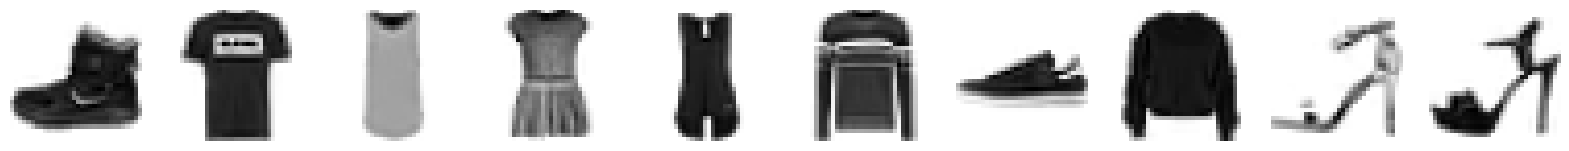

In [6]:
# 훈련 세트에 있는 샘플 출력하기
display(input_data)

## 2. PixelCNN 만들기 <a name="build"></a>

In [7]:
# PixelCNN 모델 정의
dist = tfp.distributions.PixelCNN(
    image_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=N_COMPONENTS,
    dropout_p=0.3,
)

# 모델 입력을 정의합니다.
image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# 로그 가능도를 손실 함수로 정의합니다.
log_prob = dist.log_prob(image_input)

# 모델을 정의합니다.
pixelcnn = models.Model(inputs=image_input, outputs=log_prob)
pixelcnn.add_loss(-tf.reduce_mean(log_prob))

## 3. PixelCNN 훈련하기 <a name="train"></a>

In [8]:
# 모델 컴파일 및 훈련
pixelcnn.compile(
    optimizer=optimizers.Adam(0.001),
)

In [9]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def generate(self):
        return dist.sample(self.num_img).numpy()

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate()
        display(
            generated_images,
            n=self.num_img,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=2)

Layer _PixelCNNNetwork was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/10
  6/469 [..............................] - ETA: 1:36 - loss: 4113.4692

469/469 [==============================] - ETA: 0s - loss: 2334.9646
Saved to ./output/generated_img_000.png


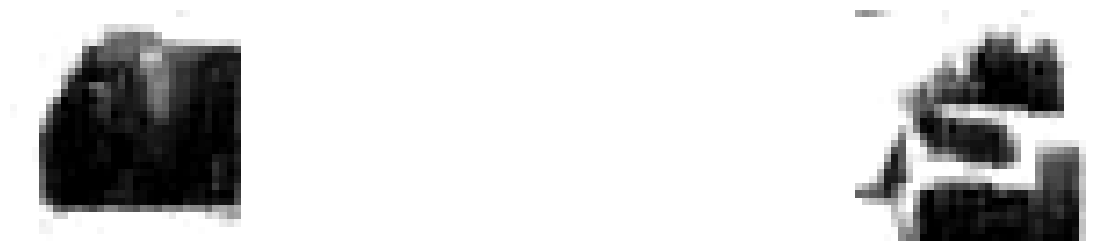

469/469 [==============================] - 239s 435ms/step - loss: 2334.9646
Epoch 2/10
469/469 [==============================] - ETA: 0s - loss: 2055.6089
Saved to ./output/generated_img_001.png


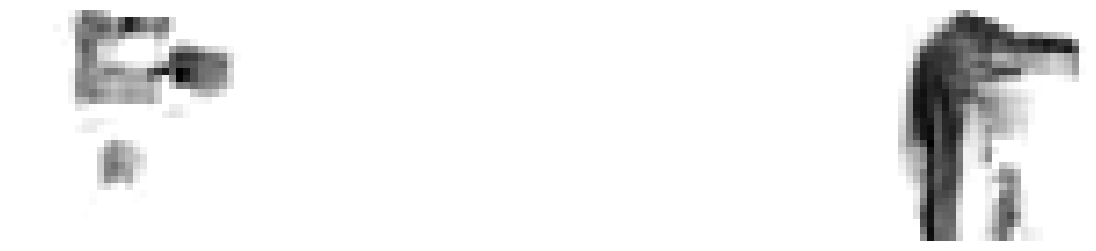

469/469 [==============================] - 201s 429ms/step - loss: 2055.6089
Epoch 3/10
469/469 [==============================] - ETA: 0s - loss: 1976.9855
Saved to ./output/generated_img_002.png


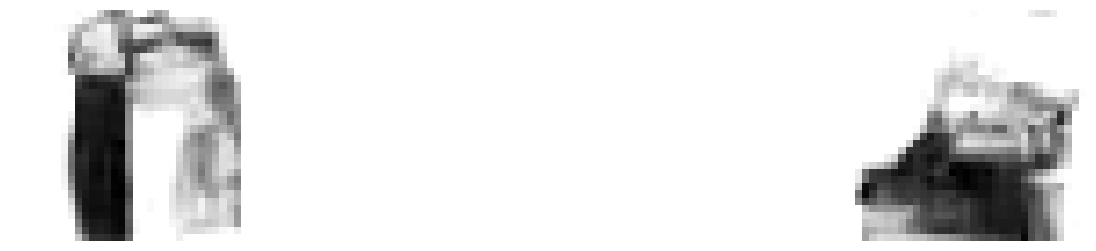

469/469 [==============================] - 200s 426ms/step - loss: 1976.9855
Epoch 4/10
469/469 [==============================] - ETA: 0s - loss: 1919.3770
Saved to ./output/generated_img_003.png


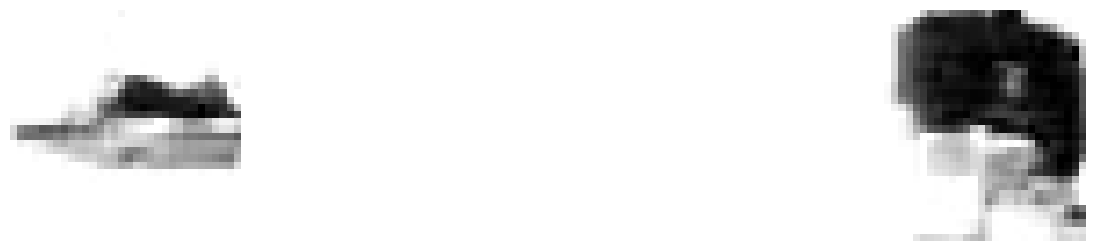

469/469 [==============================] - 200s 427ms/step - loss: 1919.3770
Epoch 5/10
469/469 [==============================] - ETA: 0s - loss: 1883.1704
Saved to ./output/generated_img_004.png


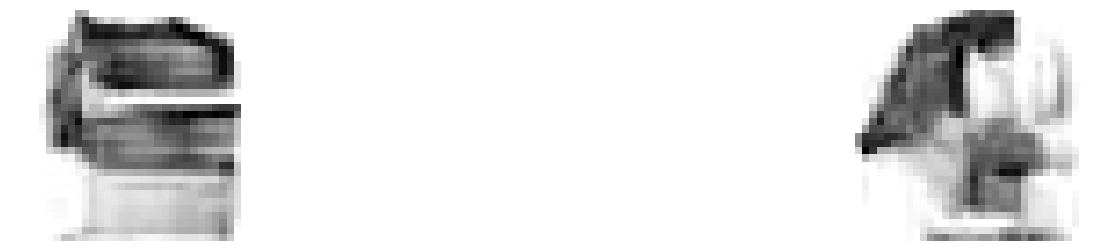

469/469 [==============================] - 207s 441ms/step - loss: 1883.1704
Epoch 6/10
469/469 [==============================] - ETA: 0s - loss: 1856.3076
Saved to ./output/generated_img_005.png


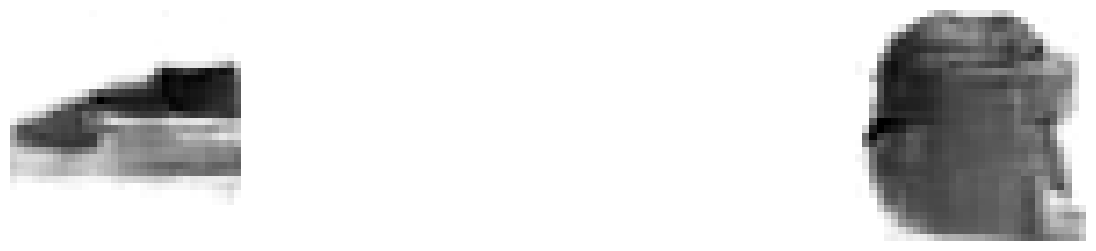

469/469 [==============================] - 201s 428ms/step - loss: 1856.3076
Epoch 7/10
469/469 [==============================] - ETA: 0s - loss: 1830.2920
Saved to ./output/generated_img_006.png


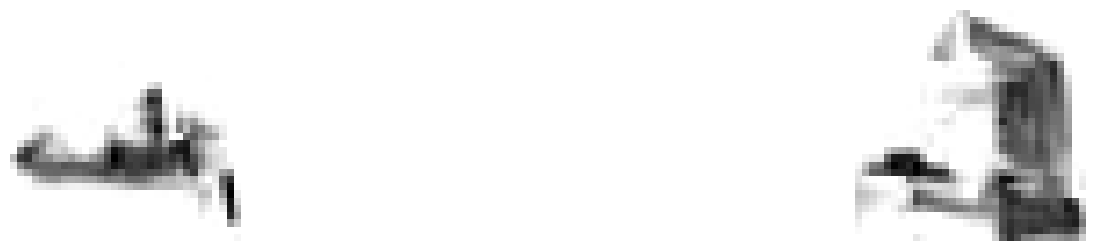

469/469 [==============================] - 201s 429ms/step - loss: 1830.2920
Epoch 8/10
469/469 [==============================] - ETA: 0s - loss: 1815.5918
Saved to ./output/generated_img_007.png


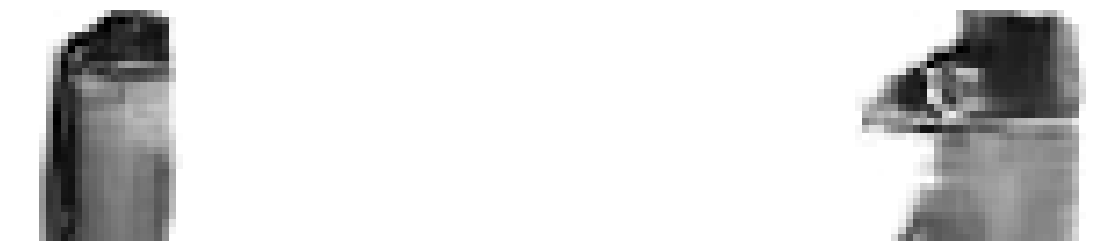

469/469 [==============================] - 200s 428ms/step - loss: 1815.5918
Epoch 9/10
469/469 [==============================] - ETA: 0s - loss: 1798.0573
Saved to ./output/generated_img_008.png


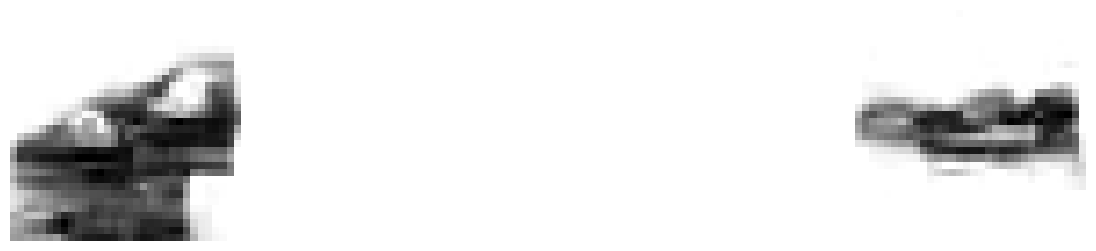

469/469 [==============================] - 201s 429ms/step - loss: 1798.0573
Epoch 10/10
469/469 [==============================] - ETA: 0s - loss: 1782.5775
Saved to ./output/generated_img_009.png


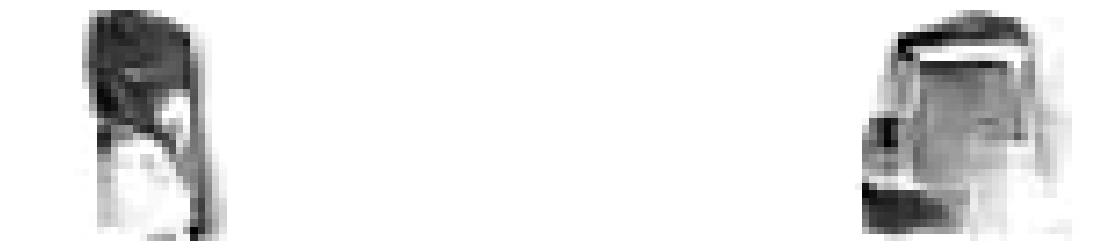

469/469 [==============================] - 201s 428ms/step - loss: 1782.5775


In [10]:
pixelcnn.fit(
    input_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=True,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4. 이미지 생성하기 <a name="generate"></a>

In [11]:
generated_images = img_generator_callback.generate()

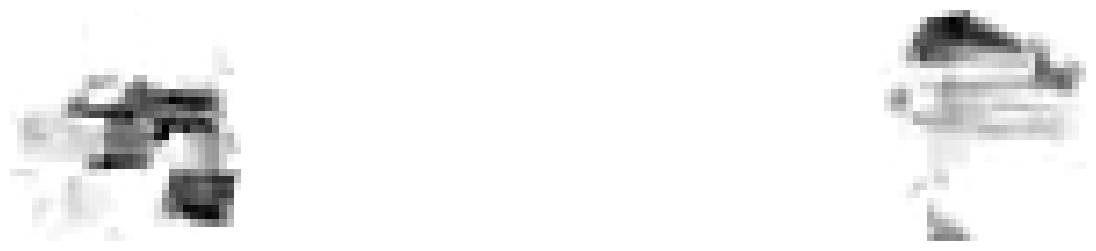

In [12]:
display(generated_images, n=img_generator_callback.num_img)